S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [4]:
import statsmodels.graphics.tsaplots as sgt
import pandas as pd

data = pd.read_csv('./data/data.csv', parse_dates=["Date"], index_col = ["Date"])
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


<AxesSubplot:xlabel='Date'>

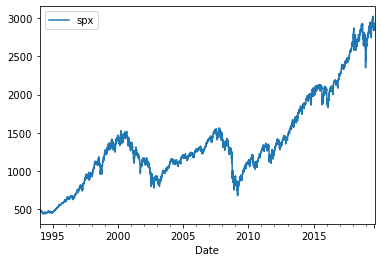

In [5]:
%matplotlib inline 
data.plot()

In [6]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

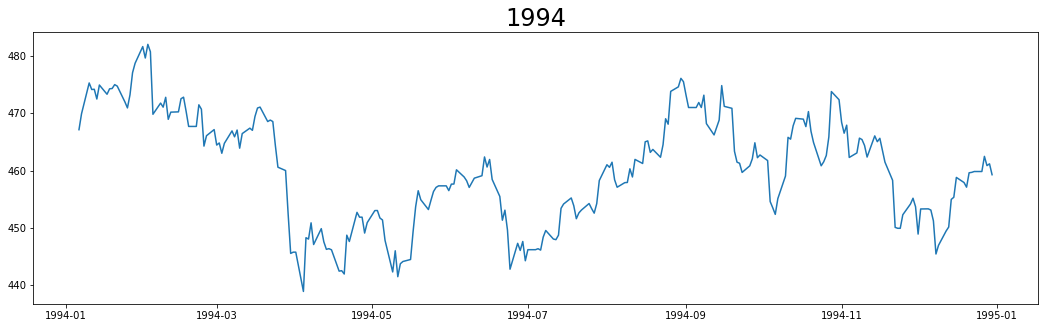

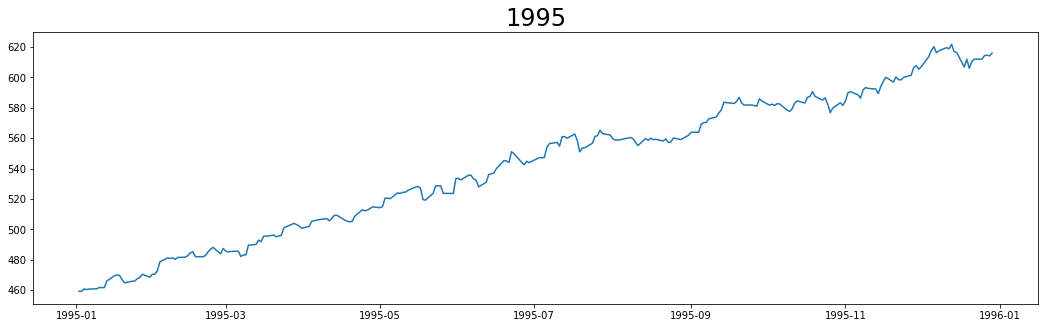

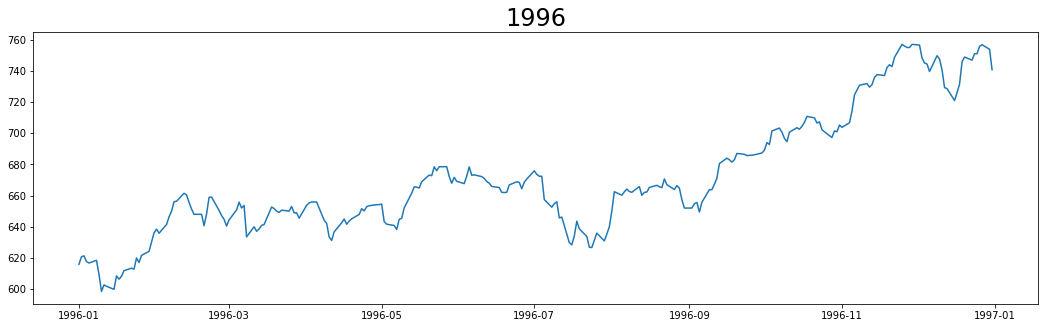

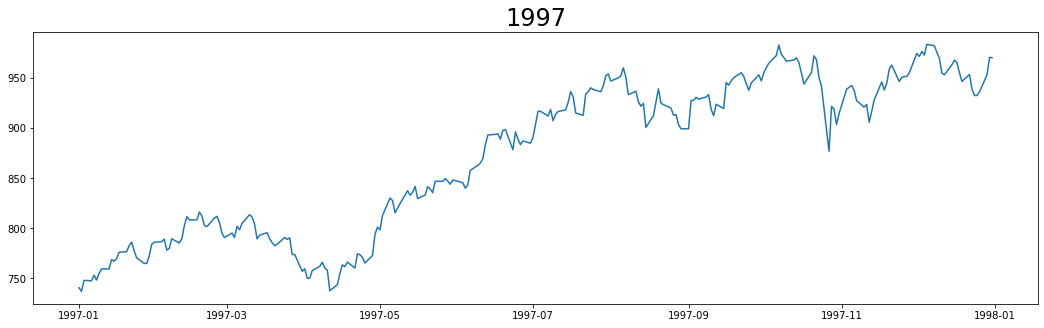

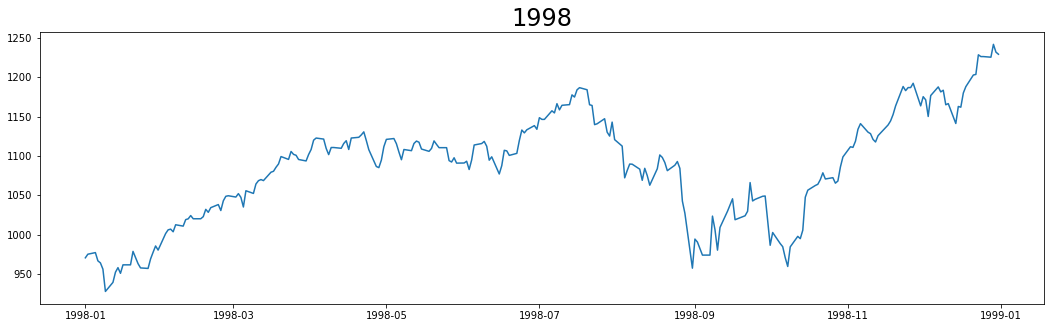

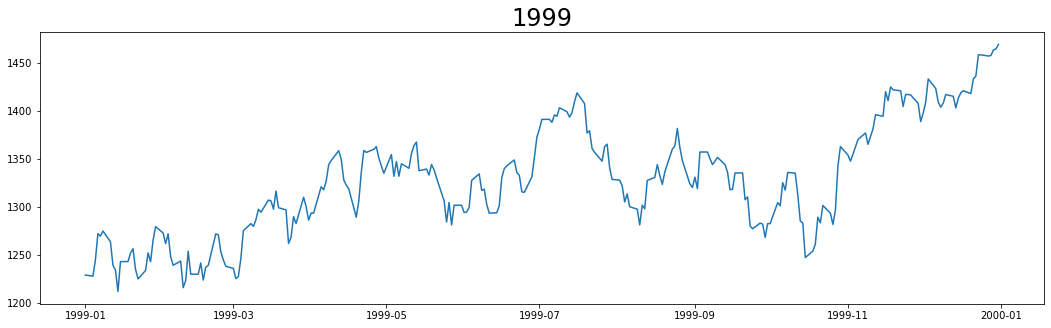

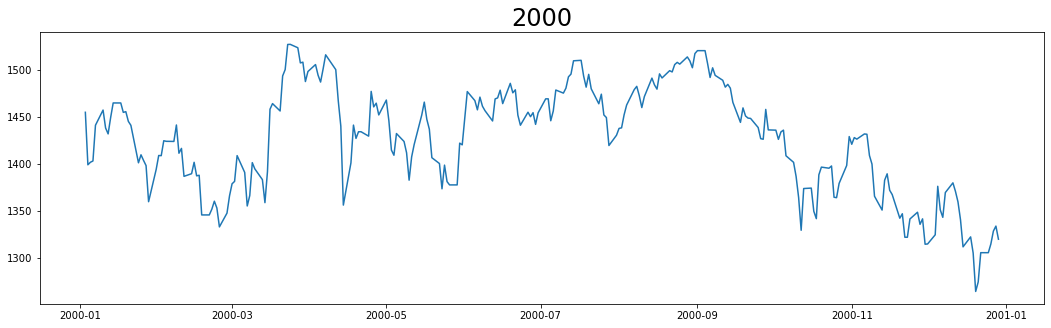

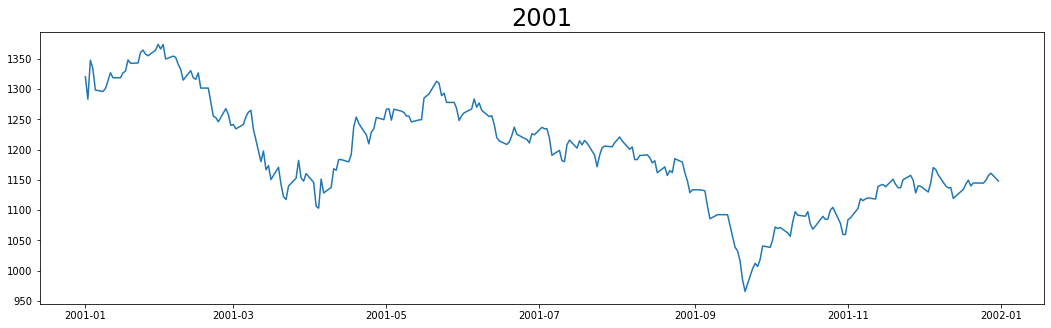

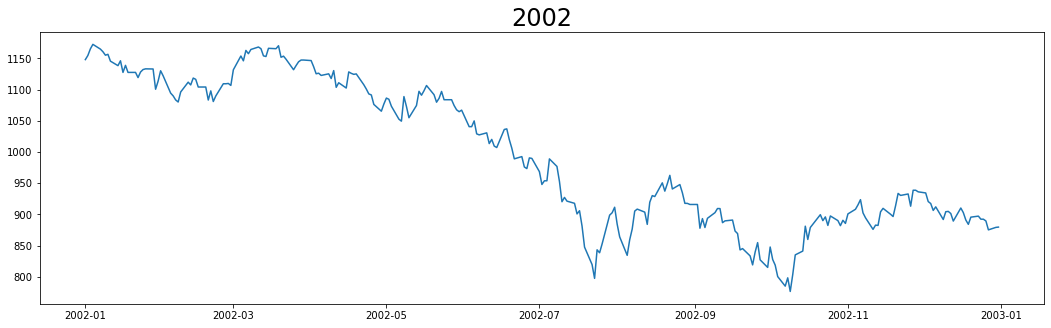

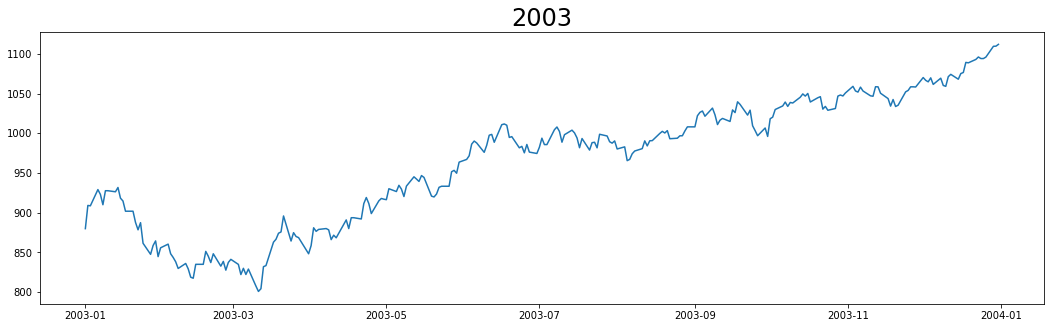

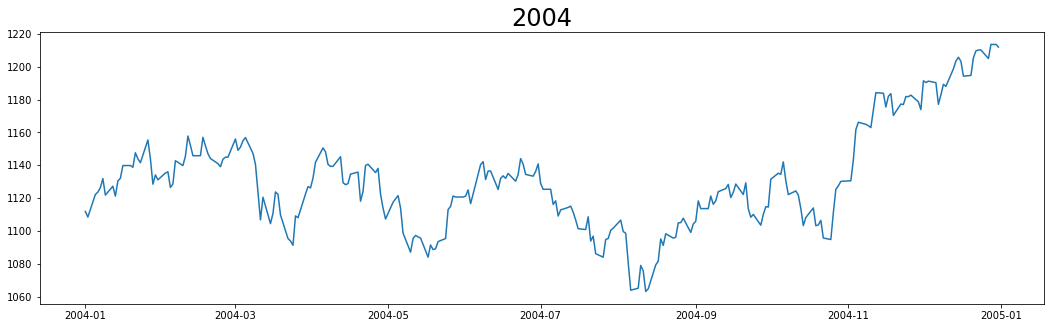

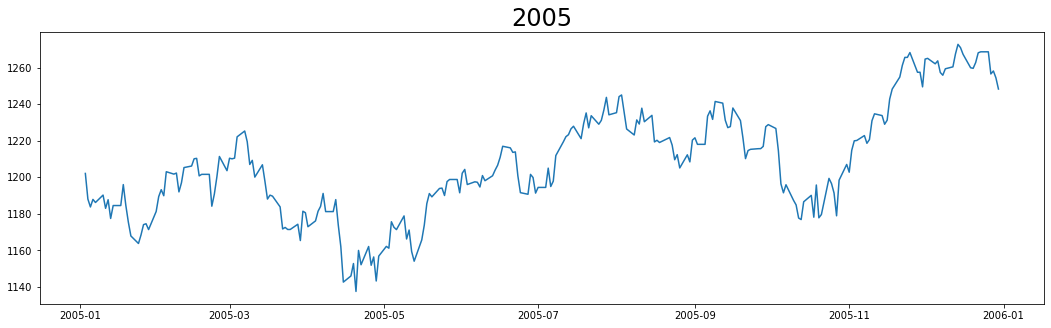

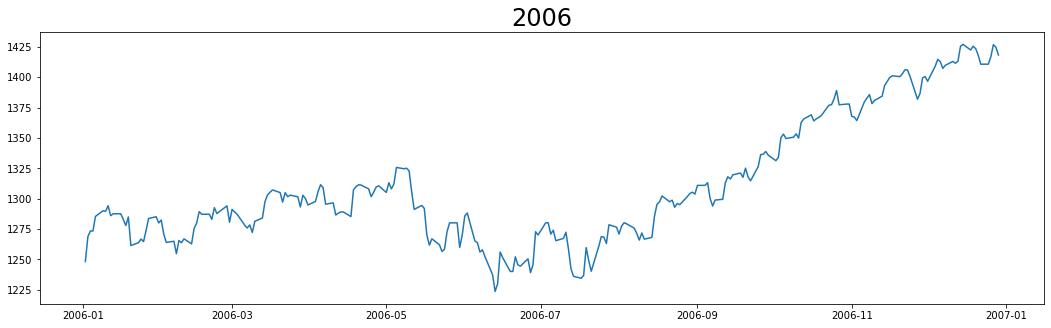

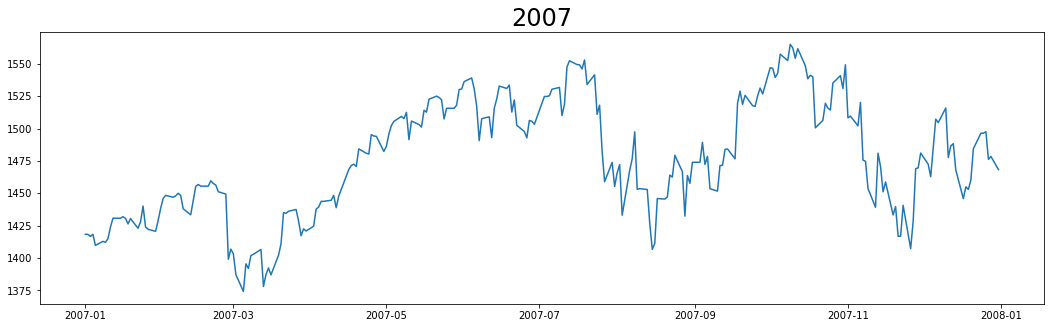

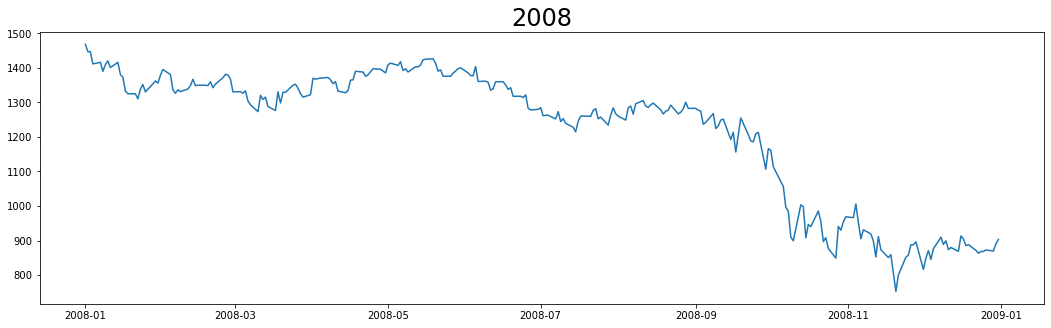

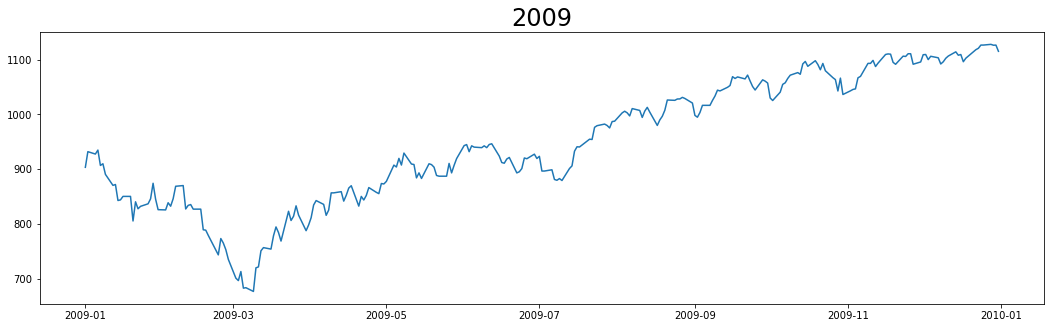

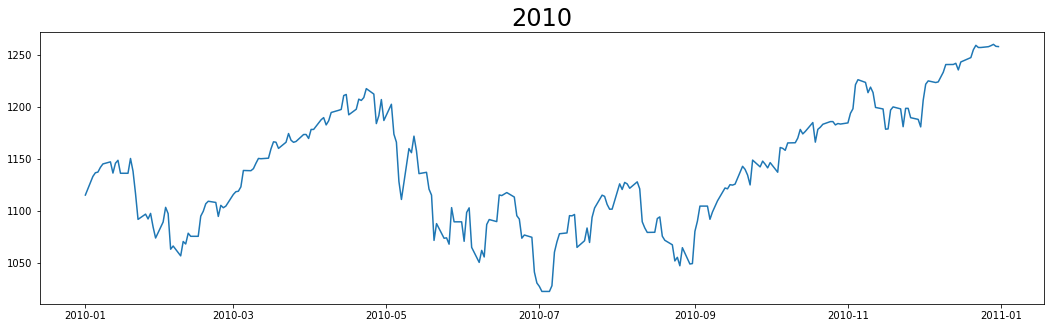

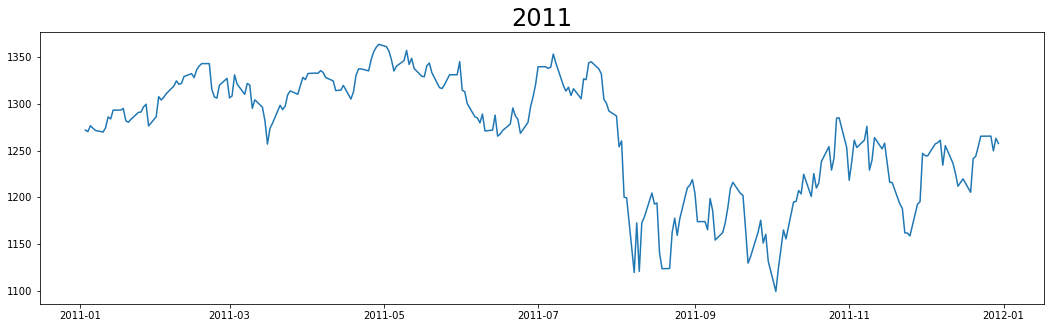

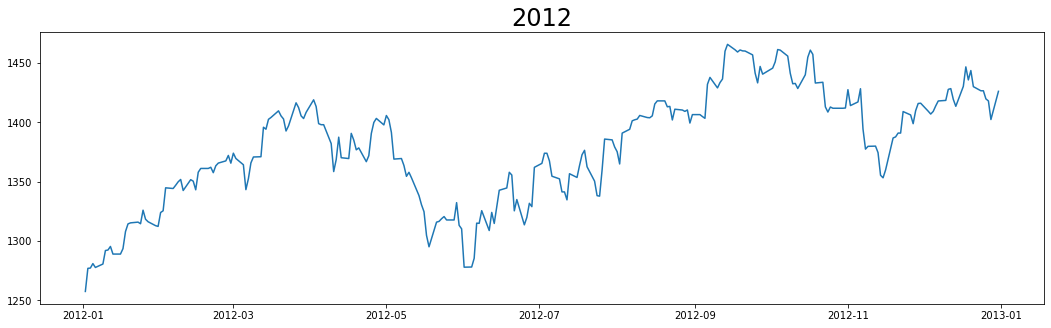

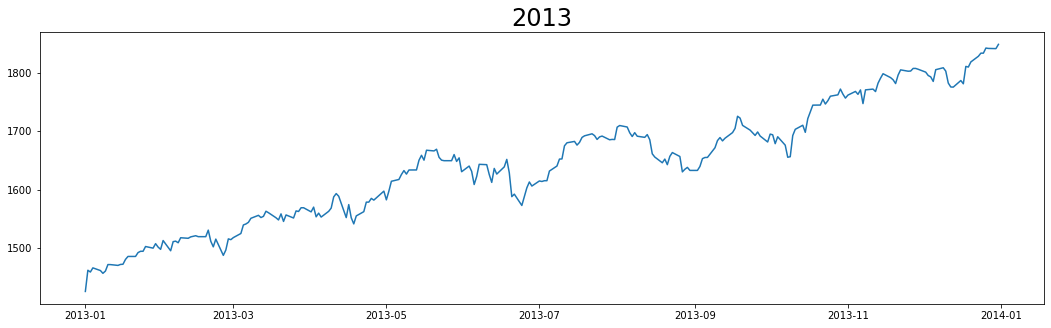

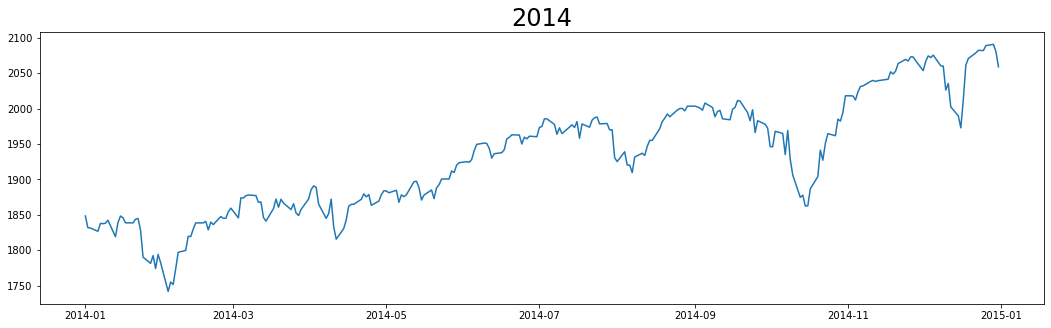

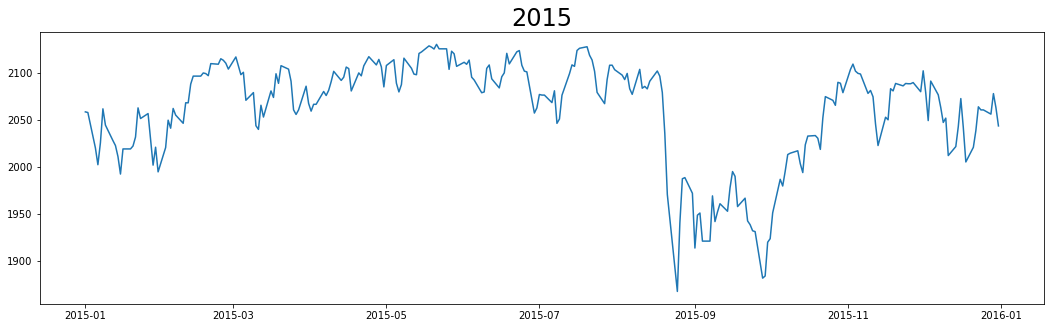

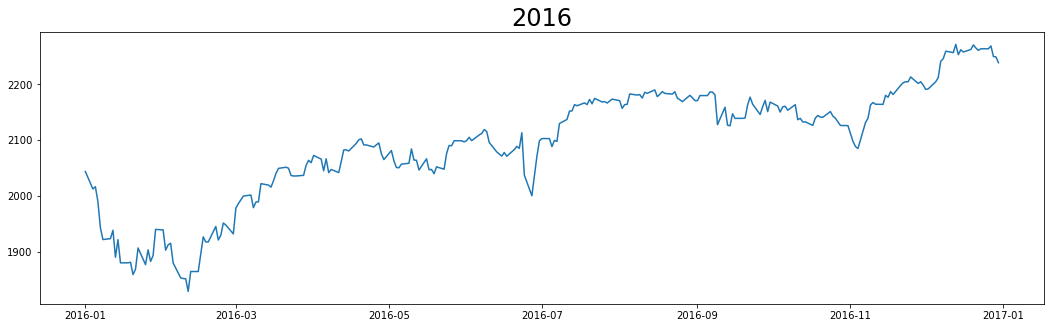

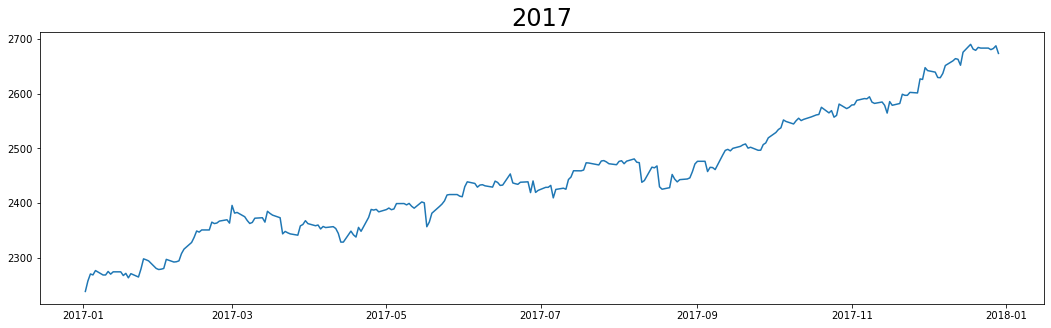

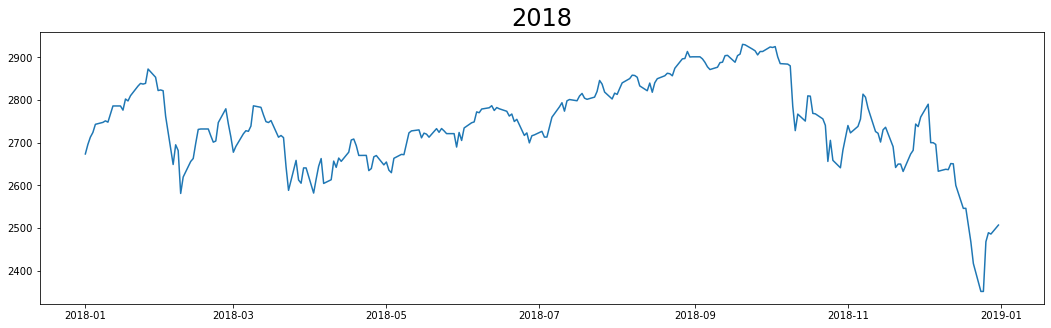

In [7]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[["spx"]].loc[train_df.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

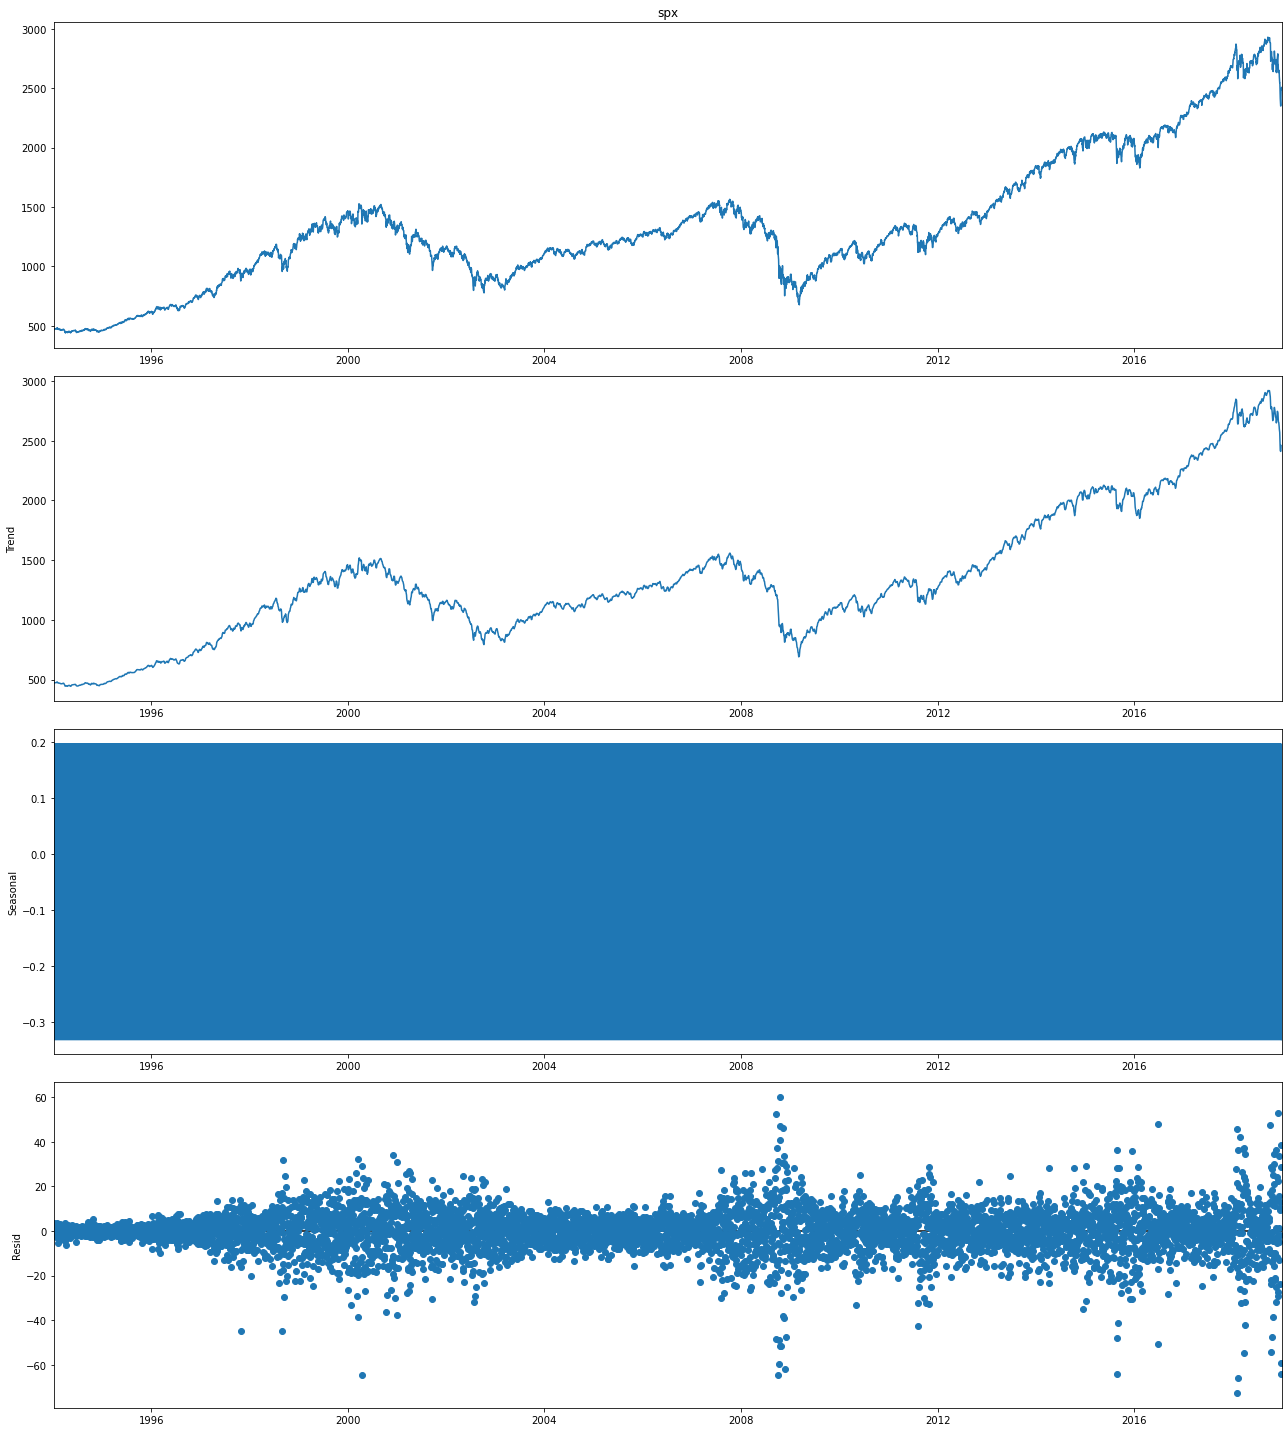

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.spx, model='additive')
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

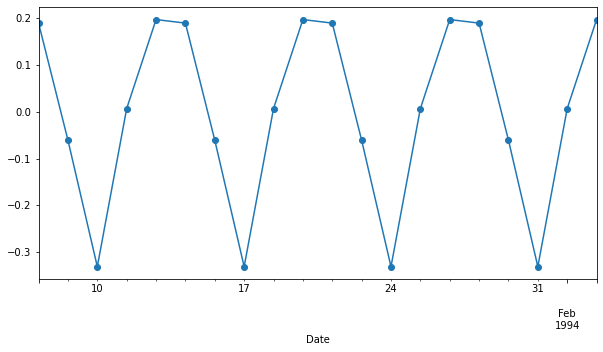

In [9]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

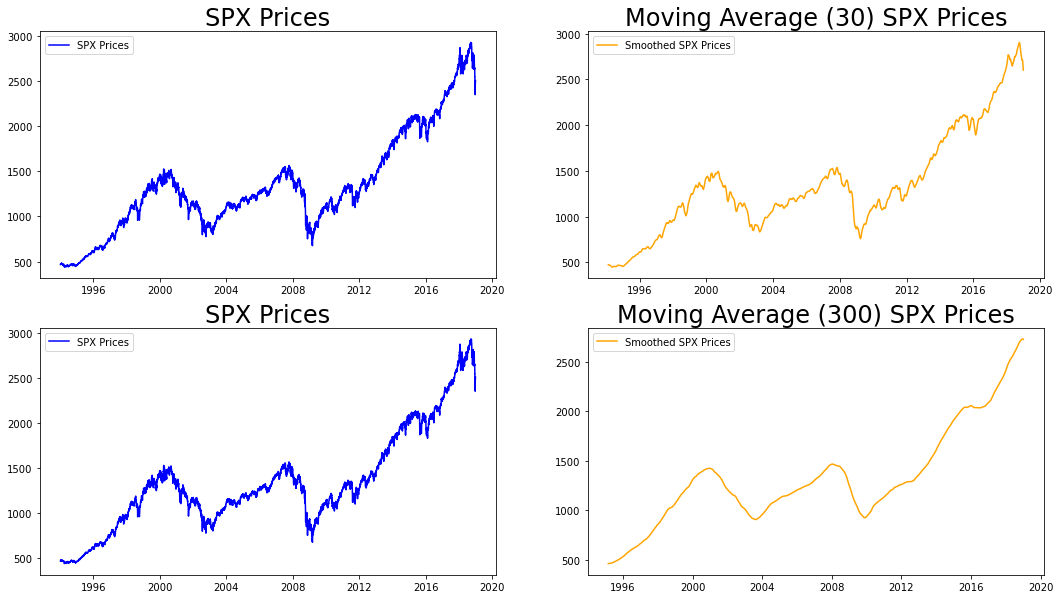

In [10]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30) 
ax[0, 0].plot(train_df.spx, color = "blue", label = "SPX Prices")
ax[0, 0].set_title("SPX Prices", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df.spx.rolling(window=30).mean(), color = "orange", label = "Smoothed SPX Prices")
ax[0, 1].set_title("Moving Average (30) SPX Prices", size = 24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.spx, color = "blue", label = "SPX Prices")
ax[1, 0].set_title("SPX Prices", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df.spx.rolling(window=300).mean(), color = "orange", label = "Smoothed SPX Prices")
ax[1, 1].set_title("Moving Average (300) SPX Prices", size = 24)
ax[1, 1].legend()

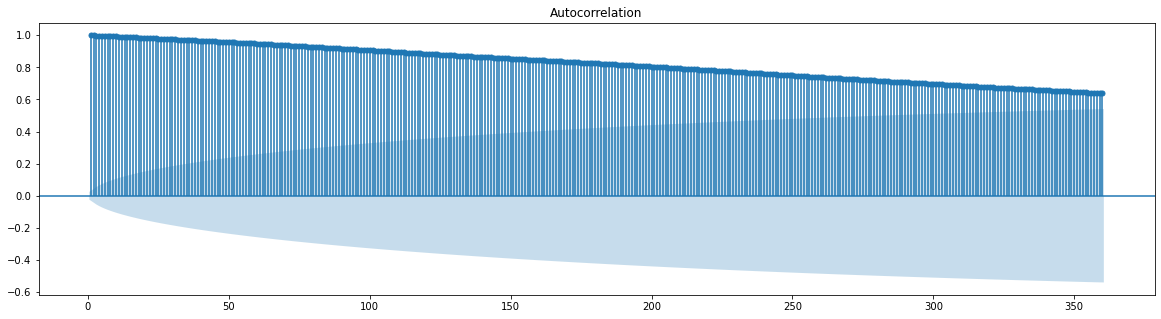

In [11]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.spx, zero = False, lags = 360)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

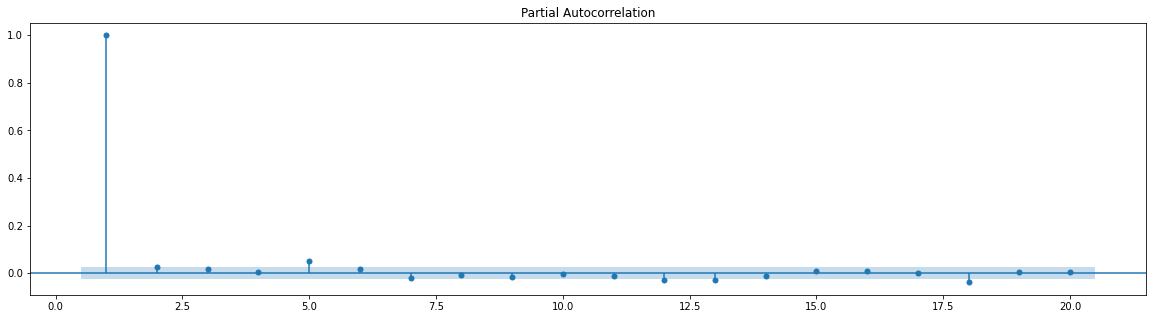

In [12]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.spx, zero = False, lags = 20)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [13]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["spx"])

(-0.3312809396965263,
 0.9209556878912154,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [14]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, lags = 40, ax = axes[1])
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

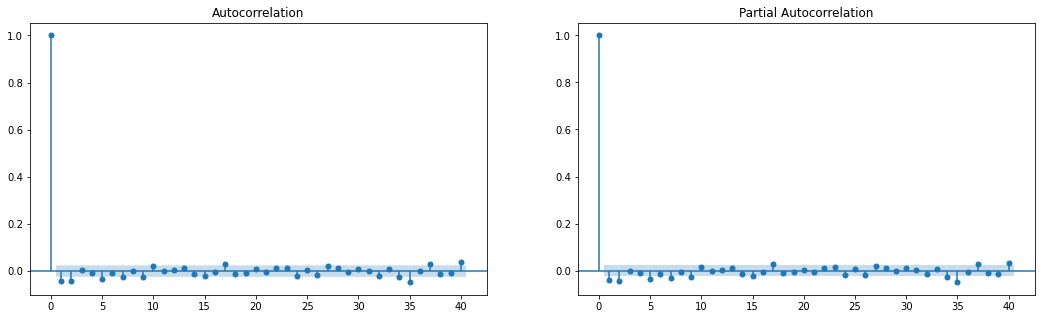

(-27.32625020173116,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [15]:
plot_acf_pacf(train_df["spx"].diff(1).dropna())
adfuller(train_df["spx"].diff(1).dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [16]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["spx"].dropna(), order = (1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Tue, 10 Jan 2023   AIC                          53257.350
Time:                        00:34:30   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_df["spx"].dropna(), order = (1, 1, 1))
model_fit = model.fit()
model_fit.summary()

C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26625.675
Date:                Tue, 10 Jan 2023   AIC                          53257.350
Time:                        00:34:31   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [18]:
seas_model = SARIMAX(train_df["spx"].dropna(), order = (1, 1, 2), seasonal_order = (1, 1, 2, 5))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manych\anaconda3\lib\site-packages\statsmodels\base\model.py:5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood              -26617.829
Date:                           Tue, 10 Jan 2023   AIC                          53249.657
Time:                                   00:35:32   BIC                          53297.127
Sample:                               01-06-1994   HQIC                         53266.074
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1556      0.169      0.919      0.358      -0.176       0.487
ma.L1         -0.1986      0.169     -1.178      0.239      -0.529       0.132
ma.L2         -0.0333      0.011     -2.900      0.004      -0.056      -0.011
ar.S.L5       -0.7733      0.081     -9.566      0.000      -0.932      -0.615
ma.S.L5       -0.2576      0.085     -3.030      0.002      -0.424      -0.091
ma.S.L10      -0.7416      0.086     -8.664      0.000      -0.909      -0.574
sigma2       206.7658      1.989    103.946      0.000     202.867     210.664
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11680.36
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = seas_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["spx"] = data["spx"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

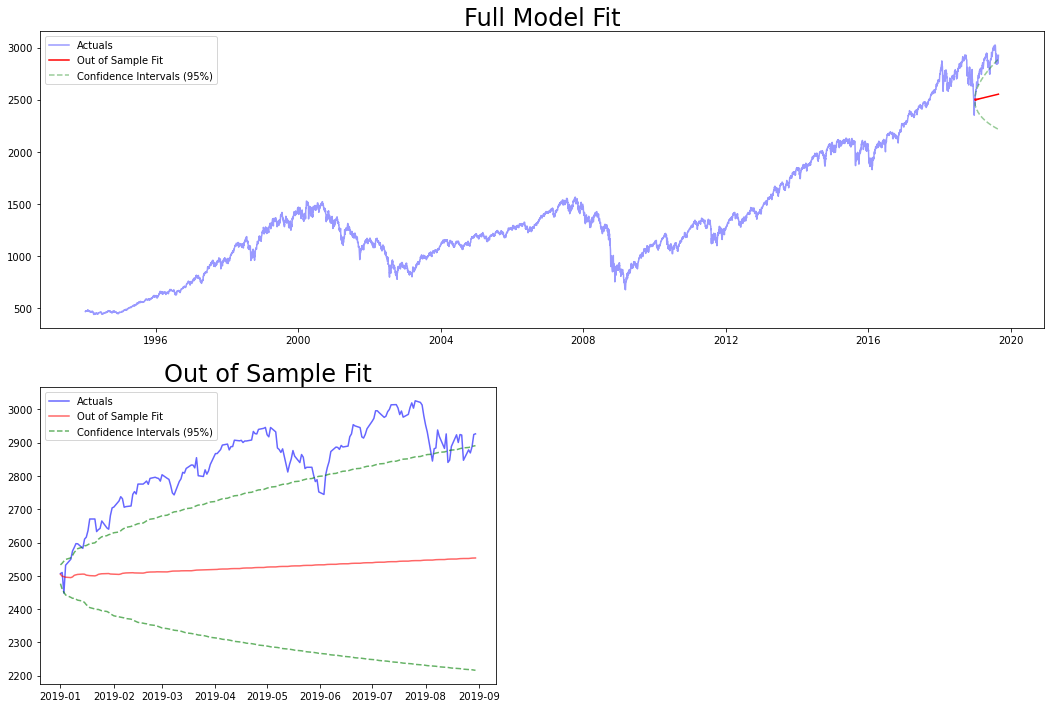

In [23]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["spx"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [21]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=7.43 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=4.18 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=2.43 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=25.51 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=6.63 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=1.34 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=3.33 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=1.57 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=39.57 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=11.24 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=3.92 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.925,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Tue, 10 Jan 2023   AIC                          55124.504
Time:                                   00:38:40   BIC                          55158.411
Sample:                                        0   HQIC                         55136.230
                                          - 6518                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Downsampling / Upsampling (Интерполяция)

In [24]:
print(data.shape)
data[(data.index>'2005-01-06') & (data.index<'2005-02-10')].head()

(6692, 1)


,spx
Date,
2005-01-07,1186.189941
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951


<AxesSubplot:xlabel='Date'>

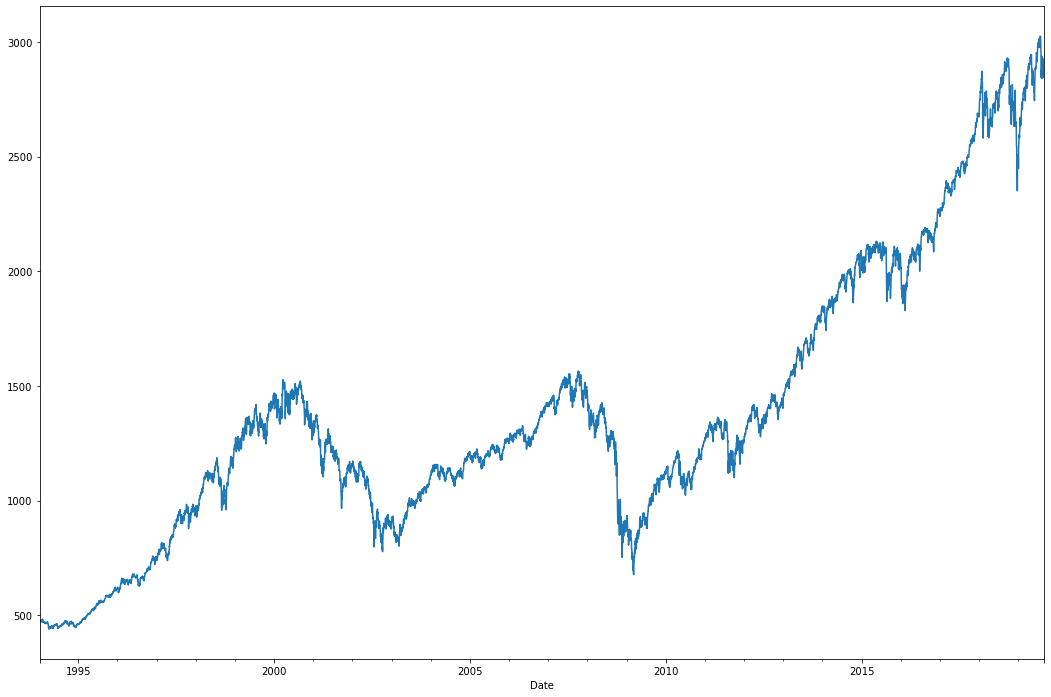

In [25]:
data.spx.plot()

(1339, 1)


<AxesSubplot:xlabel='Date'>

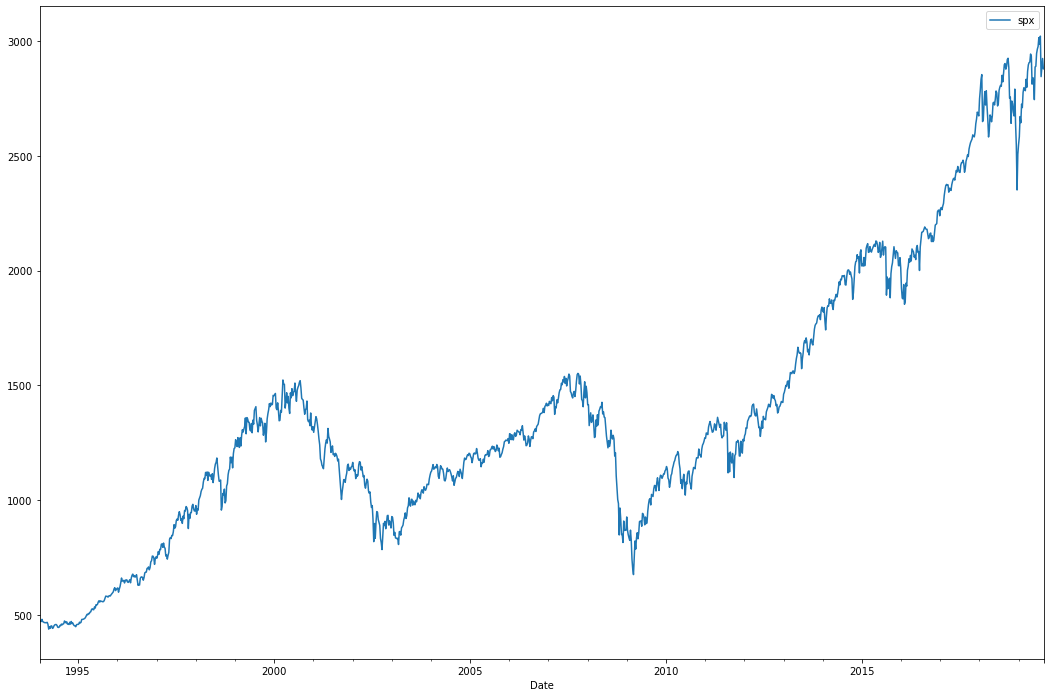

In [26]:
interpolated_data = pd.DataFrame(data.spx.resample('w-MON').interpolate(), columns = ["spx"])
print(interpolated_data.shape)
interpolated_data.plot()

In [27]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [28]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

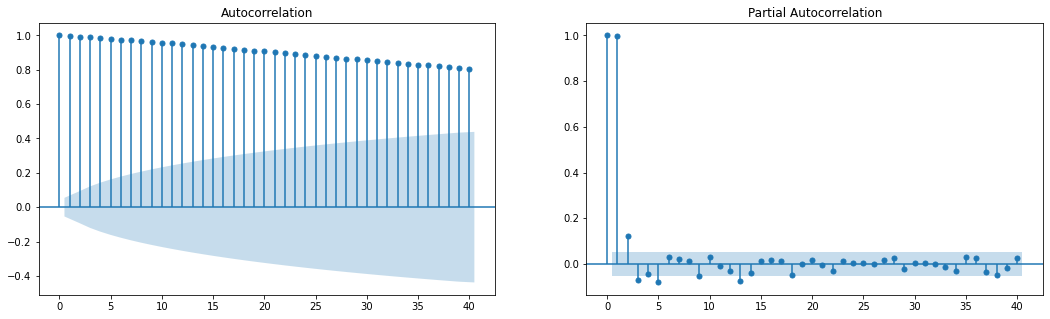

(-0.2607657143116729,
 0.9308801996019754,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [29]:
import statsmodels.graphics.tsaplots as sgt

plot_acf_pacf(train_df["spx"].dropna())
adfuller(train_df["spx"].dropna())

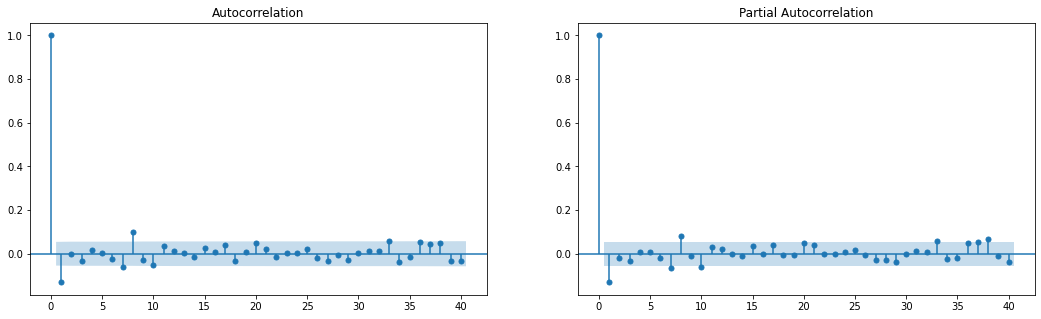

(-11.946377875600554,
 4.420358877553423e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [30]:
plot_acf_pacf(train_df["spx"].diff(1).dropna())
adfuller(train_df["spx"].diff(1).dropna())

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["spx"].dropna(), order = (1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6359.035
Date:                Tue, 10 Jan 2023   AIC                          12724.070
Time:                        00:59:18   BIC                          12739.587
Sample:                    01-10-1994   HQIC                         12729.891
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      0.137      0.157      0.875      -0.247       0.290
ma.L1         -0.1545      0.132     -1.173      0.241      -0.413       0.104
sigma2      1015.0733     20.021     50.701      0.000     975.833    1054.314
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2373.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
pred_df = pd.DataFrame(index = interpolated_data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["spx"] = interpolated_data["spx"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

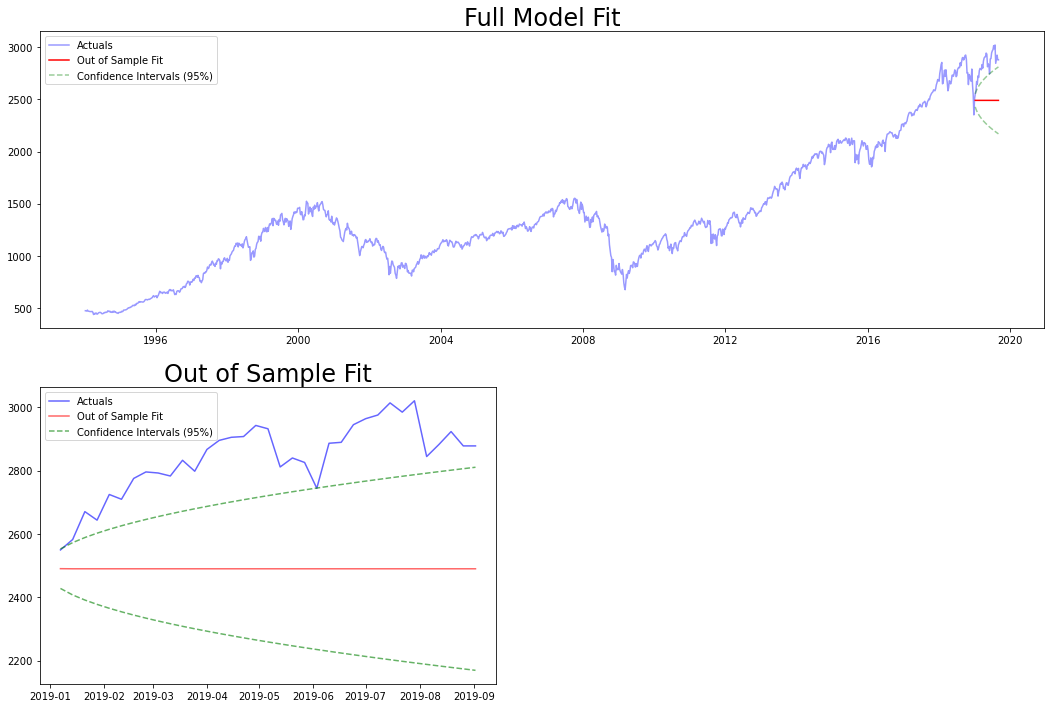

In [33]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["spx"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

## Волатильность 

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [34]:
# data["spx_vol"] = (data.spx - data.spx.shift(1))/data.spx.shift(1)
data["spx_vol"] = data.spx.pct_change(1).mul(100).abs()
data["spx_vol"].head()

Date
1994-01-06         NaN
1994-01-07    0.595136
1994-01-10    1.142795
1994-01-11    0.239860
1994-01-12    0.008438
Name: spx_vol, dtype: float64

<AxesSubplot:xlabel='Date'>

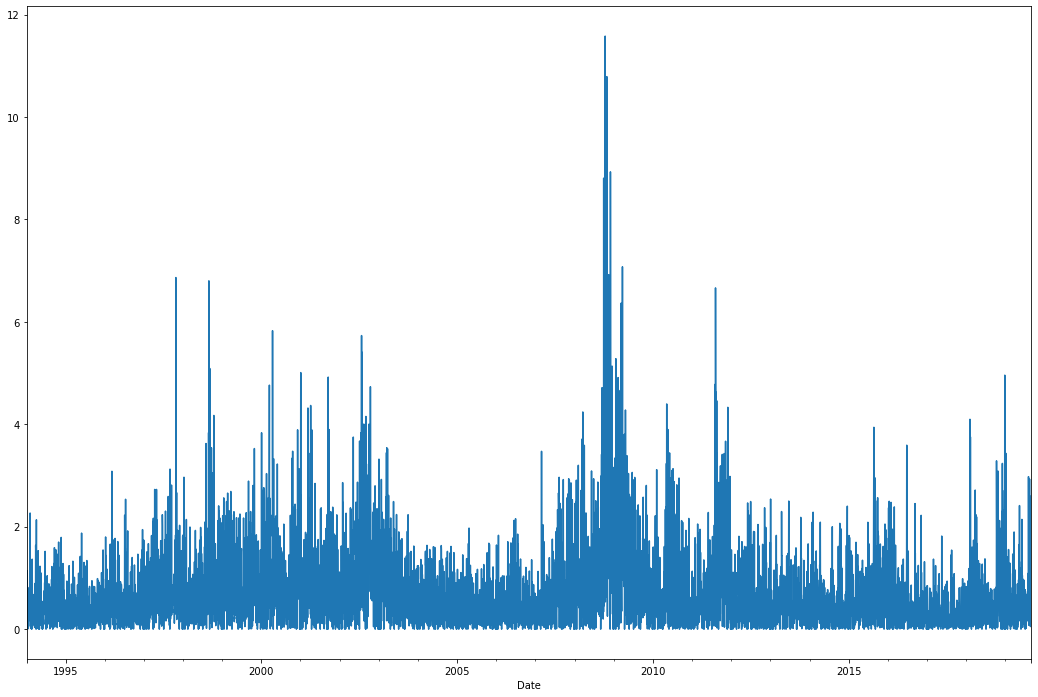

In [35]:
data["spx_vol"].plot()

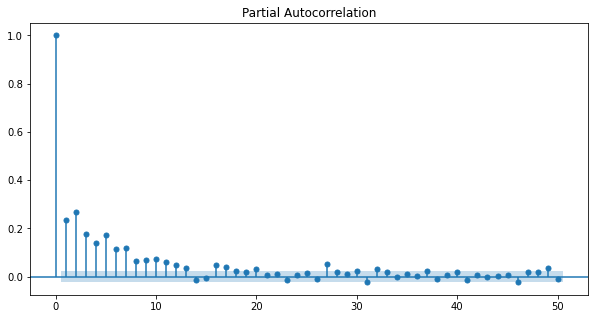

In [36]:
from matplotlib import pyplot as plt
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.spx_vol[1:], lags = 50)
plt.show()

In [37]:
adfuller(train_df.spx_vol[1:])

(-6.395349225292457,
 2.0573554561892037e-08,
 32,
 6484,
 {'1%': -3.4313589282423522,
  '5%': -2.8619858596459524,
  '10%': -2.567007327763762},
 14596.425117785417)

Глядя на графики PACF для доходности и волатильности, становится ясно, что самый значтельный - 2 лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(2, 2).

In [38]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["spx_vol"].loc[data.index]) 
# garch_df = data[['spx_vol']].copy()
# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df. 
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее 
# для сглаживания, то необходимо передать измененный train_df датасет. 

garch_df.loc[train_df.index, "spx_vol"] = train_df["spx_vol"].dropna()

In [36]:
from arch import arch_model
model = arch_model(garch_df["spx_vol"].dropna(), p = 2, q = 2, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     50,   Neg. LLF: 7099.575053673434
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6534.059785845555
Iteration:     15,   Func. Count:    128,   Neg. LLF: 6509.361020332575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6509.361009200937
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17


In [37]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6509.36
Distribution:                  Normal   AIC:                           13030.7
Method:            Maximum Likelihood   BIC:                           13071.4
                                        No. Observations:                 6517
Date:                Sun, Dec 11 2022   Df Residuals:                     6516
Time:                        18:11:30   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5505  1.077e-02     51.120      0.000 [  0.529,  0.572]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0137  3.619e-03      3.773  1.611e-04 [6.563e-03,2.075e-02]
alpha[1]       0.0704  1.850e-02      3.803  1.428e-04   [3.410e-02,  0.107]
alpha[2]       0.1162  2.731e-02      4.256  2.079e-05   [6.271e-02,  0.170]
beta[1]        0.1568  8.870e-02      1.768  7.710e-02  [-1.705e-02,  0.331]
beta[2]        0.6444  8.451e-02      7.625  2.432e-14     [  0.479,  0.810]
============================================================================

Covariance estimator: robust
"""

In [38]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

/home/kerkuri/Code_proje/SF/sf_env/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


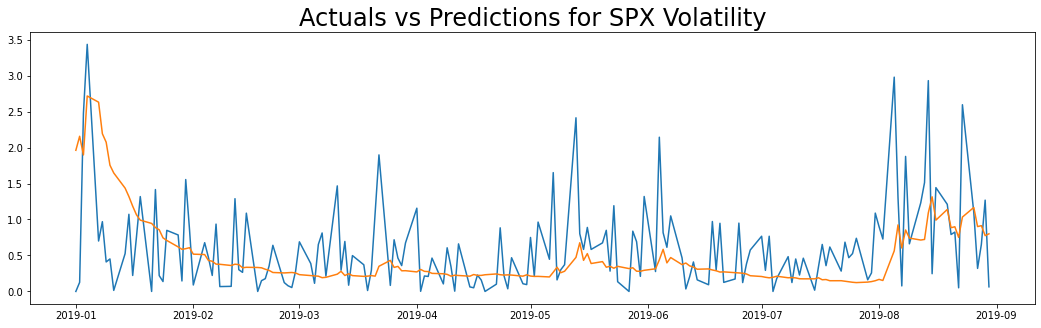

In [39]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["spx_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size = 24)

plt.show()

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predictions_df["spx_vol"].abs(), predictions_df["Predictions"]))

0.6487772438535963

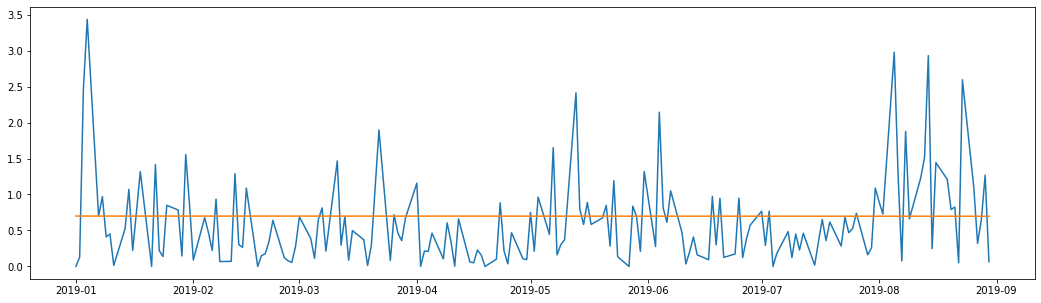

In [41]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data['spx_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['spx_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['spx_vol'].fillna(0)
y_test = test_df['spx_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

In [50]:
from arch import arch_model